# Session 4 Solution - Calculate NDVI Part 2 Exercise

## Open and run notebook

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import sys
import datacube

sys.path.append("../Scripts")
from deafrica_datahandling import load_ard
from deafrica_plotting import rgb
from deafrica_plotting import display_map
from odc.algo import xr_geomedian

In [2]:
dc = datacube.Datacube(app="Calculate_ndvi")

In the following cell, we set x and y equal to "tuples" (pairs) indicating the longitude and latitude extents of our region of interest, and then display a map showing the region.

In [3]:
x=(-6.1495, -6.1380)
y=(13.9182, 13.9111)

display_map(x, y)

### Making changes to the load cell
#### Adding nir measurement

Here we load data via the ```load_ard``` function.  We specify the instance of the datacube (```dc```), the product that we wish to load (```s2_l2a``` for Sentinel-2), the extents of our query (in x, y, and time), the list of bands to fetch (```['red' ,'green', 'blue', 'nir']```), the spatial resolution of our data (20 meters), and we group nearby results by solar day.

In [4]:
sentinel_2_ds = load_ard(
    dc=dc,
    products=["s2_l2a"],
    x=x, y=y,
    time=("2019-01", "2019-12"),
    output_crs="EPSG:6933",
    measurements=['red', 'green', 'blue', 'nir'],
    resolution=(-10, 10),
    group_by='solar_day')

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying pixel quality/cloud mask
Loading 71 time steps


### Plot timesteps

Here we create a list of time slices to plot, and store it as the variable ```timesteps```.  The values in the list are indices into the list of satellite acquisitions, starting at zero.  The values here, ```[1, 6, 8]```, therefore refer to the second, seventh, and ninth acquisitions.  There should be 71 acquisitions for this particular dataset/extent combination, so any values from 0 to 70 can be used.

We then call the ```rgb``` function to produce a series of plots from the data that we loaded, using the bands that we specify (```['red', 'green', 'blue']```), for the time indices stored in ```timesteps```.

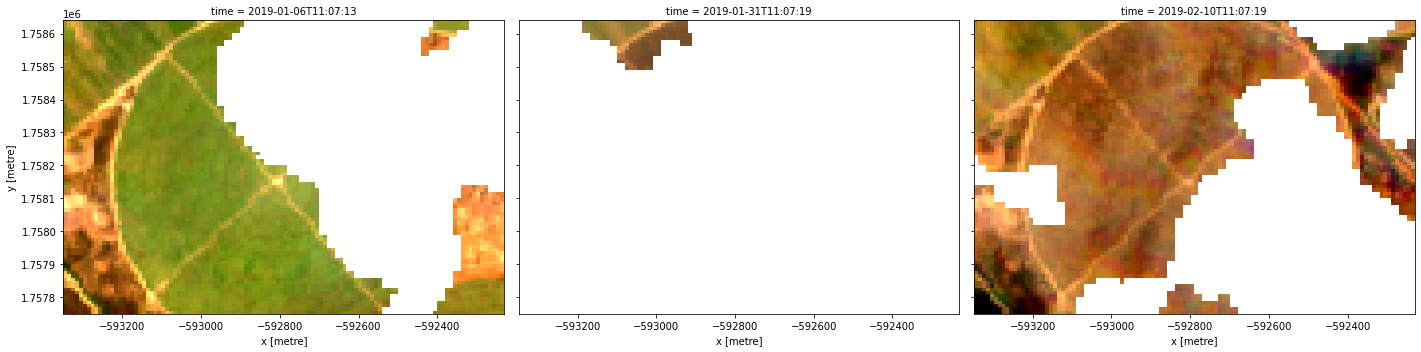

In [5]:
timesteps = timesteps = [1, 6, 8]

rgb(sentinel_2_ds, bands=['red', 'green', 'blue'], index=timesteps, size=5)

### Resampling the dataset

Here we create a new variable (```resample_sentinel_2_ds```) which describes a grouping of the data we previously loaded (```sentinel_2_ds```), divided into 3-month (quarterly) intervals.

In [6]:
resample_sentinel_2_ds = sentinel_2_ds.resample(time='3MS')

### Compute the geomedian

Below, we take the data which we just split into quarterly intervals, and we apply the ```xr_geomedian``` function to each interval.  We store the result into the ```geomedian_resample``` variable.

In [7]:
geomedian_resample = resample_sentinel_2_ds.map(xr_geomedian)

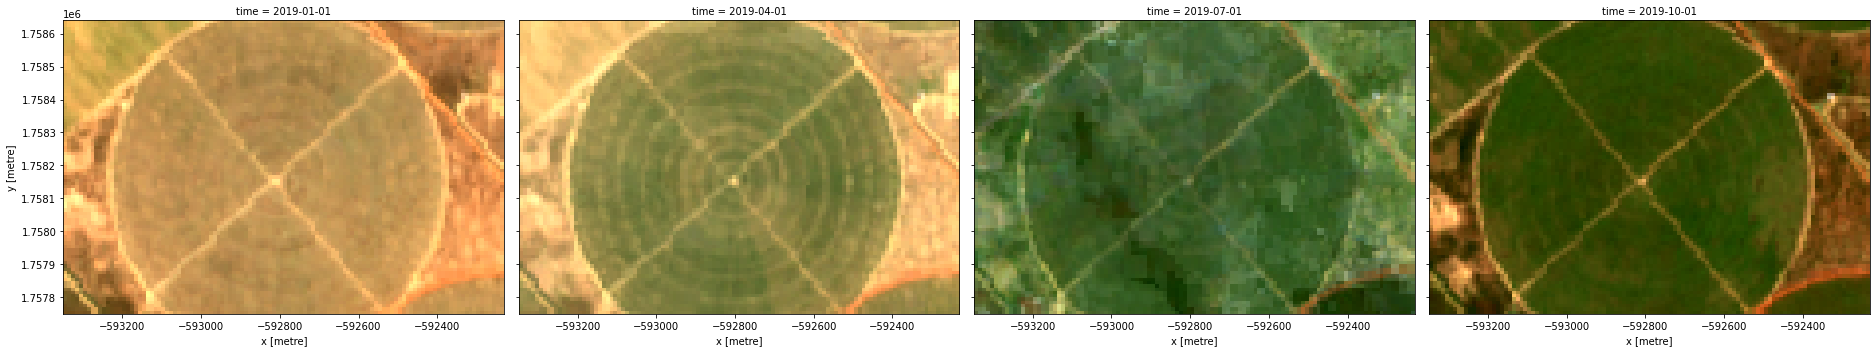

In [8]:
rgb(geomedian_resample, bands=['red', 'green', 'blue'], col="time", col_wrap=4, size=5)

### Comparing the two datasets

In the next two cells, we simply print our datasets to screen.  The first cell contains the data that we originally loaded from the Open Data Cube, and the second cell contains the data after resampling it into quarterly geomedian composites.  Note that the first dataset contains many more time slices than the second.

In [9]:
sentinel_2_ds

<xarray.Dataset>
Dimensions:      (time: 71, x: 112, y: 89)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-01T11:07:16 ... 2019-12-27T11:...
    spatial_ref  int32 6933
  * y            (y) float64 1.759e+06 1.759e+06 ... 1.758e+06 1.758e+06
  * x            (x) float64 -5.933e+05 -5.933e+05 ... -5.922e+05 -5.922e+05
Data variables:
    red          (time, y, x) float32 1192.0 1272.0 1290.0 ... 927.0 939.0 938.0
    green        (time, y, x) float32 1036.0 1092.0 1104.0 ... 935.0 985.0 971.0
    blue         (time, y, x) float32 766.0 808.0 785.0 ... 545.0 550.0 530.0
    nir          (time, y, x) float32 2740.0 2812.0 2866.0 ... 3306.0 3242.0
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

In [10]:
geomedian_resample

<xarray.Dataset>
Dimensions:  (time: 4, x: 112, y: 89)
Coordinates:
  * time     (time) datetime64[ns] 2019-01-01 2019-04-01 2019-07-01 2019-10-01
  * y        (y) float64 1.759e+06 1.759e+06 1.759e+06 ... 1.758e+06 1.758e+06
  * x        (x) float64 -5.933e+05 -5.933e+05 ... -5.922e+05 -5.922e+05
Data variables:
    red      (time, y, x) float32 1654.7893 1770.8843 ... 665.5554 694.822
    green    (time, y, x) float32 1348.7592 1409.6754 ... 723.7687 739.2761
    blue     (time, y, x) float32 837.38544 882.7103 ... 359.04172 380.6102
    nir      (time, y, x) float32 3740.0647 3712.3347 ... 3000.3389 2931.3264

### Manually calculate an index
#### Calculate NDVI

In the following cell, we compute NDVI values from our resampled data using the formula: $$ NDVI = \frac{(NIR - Red) }{ (NIR + Red)} $$
To keep our code tidy, we create variables ```nir``` and ```red``` and set them to equal ```geomedian_resample.nir``` and ```geomedian_resample.red``` respectively.

In [11]:
nir = geomedian_resample.nir
red = geomedian_resample.red

NDVI = (nir - red) / (nir + red)

### Plot NDVI for each geomedian

Here we call the ```plot``` function on our NDVI data, which gives us an image for each quarterly interval.

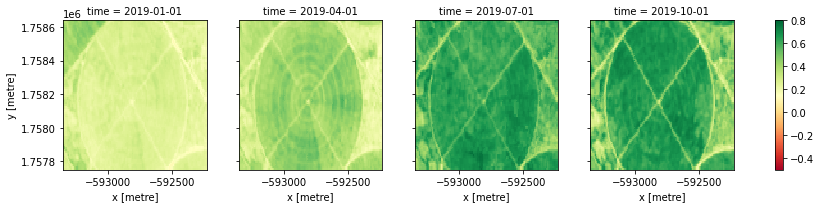

In [12]:
NDVI.plot(col='time', vmin=-0.50, vmax=0.8, cmap='RdYlGn')

### Plot time series of the NDVI area

The following cell generates a plot of the mean NDVI over time.  Note that we specify the dimensions along which to take the mean (```dim=['x', 'y']```).  It is important that we omitted the ```time``` dimension &mdash; if we had included it, our mean would collapse the data along _every_ dimension, returning only a single value (the mean value in x, y, _and_ time).

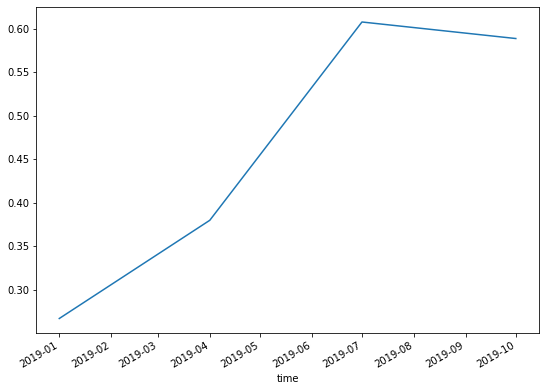

In [13]:
NDVI.mean(dim=['x', 'y']).plot(size=6)

Finally, we decorate the plot from the previous cell by adding a title and a label for our Y axis.

Text(0, 0.5, 'Mean NDVI')

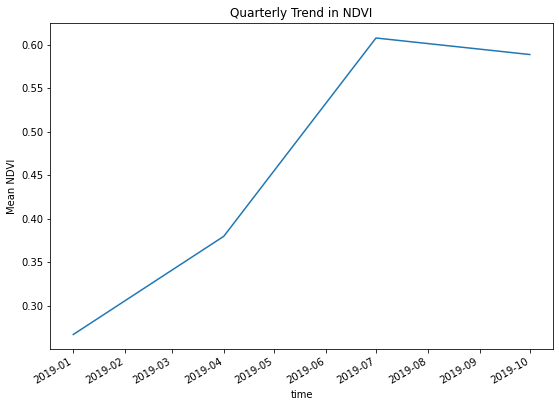

In [14]:
NDVI.mean(dim=['x', 'y']).plot(size=6)
plt.title('Quarterly Trend in NDVI')
plt.ylabel('Mean NDVI')